### document classification example
based on sklearn site example entitled "Classification of text documents using sparse features"
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html

 - some of the code appears to be out of date (e.g. old string formatting syntax)
 - much of it is also geared toward CLI runs - adapting it as a notebook
 
 The BSD 3-clause license allows you almost unlimited freedom with the software so long as you include the BSD copyright and license notice in it.

© 2007 - 2021, scikit-learn developers (BSD License). 

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
1.     Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
1.     Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission. 

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [15]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
# modified: Robert Sunderland - 2021

import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt
import pandas as pd

#changed from CLI options to inline

optdict = {'print_report': True,# Print a detailed classification report.
 'select_chi2': 1500,#Select some number of features using a chi-squared test
 'print_cm': True,#Print the confusion matrix.
 'print_top10': True, #Print ten most discriminative terms per class for every classifier
 'all_categories': True, #Whether to use all categories or not
 'use_hashing': True, #Use a hashing vectorizer
 'n_features': 2**16, #n_features when using the hashing vectorizer
 'filtered': True} #Remove newsgroup information that is easily overfit: headers, signatures, and quoting


optdict

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

In [30]:
from types import SimpleNamespace
#d = {'key1': 'value1', 'key2': 'value2'}
opts = SimpleNamespace(**optdict)
#opts.__dict__
vars(opts)

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

In [29]:
#alternative solution
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
opts = objectview(optdict)
#opts.__dict__
vars(opts)

Wall time: 0 ns


{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

# load data

In [32]:
opts.all_categories = False

In [34]:
## load data
if opts.all_categories:
    categories = None
else:
    categories = [
        "alt.atheism",
        "talk.religion.misc",
        "comp.graphics",
        "sci.space",
    ]
print(f"20 newsgroups dataset for categories:{categories if categories else 'all'}")


20 newsgroups dataset for categories:['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [35]:
if opts.filtered:
    remove = ("headers", "footers", "quotes")
else:
    remove = ()
    
remove

('headers', 'footers', 'quotes')

In [36]:
from sklearn.datasets import fetch_20newsgroups
data_train = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42, remove=remove)

data_test = fetch_20newsgroups(subset="test", categories=categories, shuffle=True, random_state=42, remove=remove)
print("data loaded")

data loaded


In [38]:
type(data_train), type(data_test)

(sklearn.utils.Bunch, sklearn.utils.Bunch)

In [39]:
# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names
target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [42]:
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print(f"{len(data_train.data)} documents - {data_train_size_mb:0.3}MB (training set)")
print(f"{len(data_test.data)} documents - {data_test_size_mb:0.3}MB (test set)")
print(f"{len(target_names)} categories")

2034 documents - 2.43MB (training set)
1353 documents - 1.8MB (test set)
4 categories


In [43]:
# split a training set and a test set
y_train, y_test = data_train.target, data_test.target
type(y_train), len(y_train), type(y_test), len(y_test)

(numpy.ndarray, 2034, numpy.ndarray, 1353)

In [47]:
opts.use_hashing = False

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words="english", alternate_sign=False, n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print(f"done in {duration:0.5}s at {data_train_size_mb / duration:0.3} MB/s" )
print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}" )

Extracting features from the training data using a sparse vectorizer
done in 0.33282s at 7.29 MB/s
n_samples: 2034, n_features: 26576


In [61]:
import sklearn
sklearn.__version__

'0.23.2'

In [71]:
f = vectorizer.get_feature_names()#Array mapping from feature integer indices to feature name.
f

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000062david42',
 '0001',
 '000100255pixel',
 '00041032',
 '0004136',
 '0004246',
 '0004422',
 '00044513',
 '0004847546',
 '0005',
 '0007',
 '00090711',
 '000usd',
 '0012',
 '001200201pixel',
 '0018',
 '00196',
 '0020',
 '0022',
 '0028',
 '0029',
 '0033',
 '0034',
 '0038',
 '0049',
 '006',
 '0065',
 '0094',
 '0098',
 '00index',
 '00pm',
 '01',
 '0100',
 '013846',
 '01752',
 '0179',
 '01821',
 '01826',
 '0184',
 '01852',
 '01854',
 '01890',
 '018b',
 '0195',
 '0199',
 '01a',
 '02',
 '020',
 '0200',
 '020359',
 '020637',
 '02115',
 '02138',
 '02139',
 '02154',
 '02178',
 '0223',
 '0235',
 '023b',
 '0245',
 '03',
 '030',
 '0300',
 '03051',
 '0330',
 '034',
 '034101',
 '04',
 '040',
 '040286',
 '0410',
 '04110',
 '041493003715',
 '0418',
 '045',
 '04g',
 '05',
 '050',
 '0500',
 '050524',
 '0511',
 '05402',
 '05446',
 '0545',
 '054589e',
 '058',
 '06',
 '060',
 '0605',
 '06111',
 '06179397',
 '06487',
 '0649',
 '067',
 '0674',
 

In [72]:
sorted(vectorizer.vocabulary_)#same as get_feature_names
vectorizer.vocabulary_['001200201pixel']

20

In [49]:
print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
#print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
#print("n_samples: %d, n_features: %d" % X_test.shape)
print(f"done in {duration:0.5}s at {data_test_size_mb / duration:0.3} MB/s" )
print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}" )

Extracting features from the test data using the same vectorizer
done in 0.18351s at 9.81 MB/s
n_samples: 1353, n_features: 26576


- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [74]:
# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    #feature_names = vectorizer.get_feature_names_out()#not in v0.23.2
    feature_names = vectorizer.get_feature_names()
pd.Series(feature_names)

0            00
1           000
2          0000
3         00000
4        000000
          ...  
26571      zwak
26572    zwakke
26573     zware
26574    zwarte
26575     zyxel
Length: 26576, dtype: object

In [82]:
from sklearn.feature_selection import SelectKBest, chi2
if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" % opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names is not None:
        # keep selected feature names
        #feature_names = feature_names[ch2.get_support()] #fails - filtering a list with a boolean?
        feature_names = pd.Series(feature_names)[ch2.get_support()].values

    print(f"done in {(time() - t0)}s" )

feature_names
#def trim(s):
#    """Trim string to fit on terminal (assuming 80-column display)"""
#    return s if len(s) <= 80 else s[:77] + "..."

Extracting 1500 best features by a chi-squared test
done in 0.0059833526611328125s


array(['00', '10', '1024x768', ..., 'yo', 'zeus', 'zip'], dtype=object)

# benchmark classifiers

In [110]:
#benchmark classifiers - utility function
from sklearn import metrics
from sklearn.utils.extmath import density
def benchmark(clf, prettyname=None, apptext = ''):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time}fs" )

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time}fs" )

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score}f" )

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}" )
        print(f"density: {density(clf.coef_)}"  )

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(f"{label}: {' '.join(feature_names[top10])}".strip() )
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0] if not prettyname else prettyname
    if len(apptext)>0: 
        clf_descr += f" {apptext}"
    
    return clf_descr, score, train_time, test_time

In [116]:
results = []
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, ))
results

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.02692699432373047fs
test time:  0.0fs
accuracy:   0.7612712490761271f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: cruel deletion islamic atheist islam motto bobby atheists atheism religion
comp.graphics: pov images card 42 hi image file 3d computer graphics
sci.space: earth sci moon flight shuttle spacecraft launch nasa orbit space
talk.religion.misc: order abortion koresh rosicrucian christ children jesus fbi christians christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.71      0.58      0.64       319
     comp.graphics       0.88      0.89      0.89       389
         sci.space       0.73      0.92      0.81       394
talk.religion.misc       0.68      0.53      0.60       251

          accuracy                           0

C:\Users\Rob.DESKTOP-HBG5EOT\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


test time:  0.11568880081176758fs
accuracy:   0.3946784922394678f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.32      0.42      0.36       319
     comp.graphics       0.49      0.48      0.48       389
         sci.space       0.47      0.45      0.46       394
talk.religion.misc       0.22      0.16      0.18       251

          accuracy                           0.39      1353
         macro avg       0.37      0.37      0.37      1353
      weighted avg       0.39      0.39      0.39      1353

confusion matrix:
[[133  47  81  58]
 [ 92 185  71  41]
 [101  78 177  38]
 [ 95  69  48  39]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.7001540660858154fs
test time:  0.044881582260131836fs
accuracy:   0.7161862527716186f
classification report:
                    precision    recall  f1-score   support

       alt.atheis

[('RidgeClassifier', 0.7612712490761271, 0.02692699432373047, 0.0),
 ('Perceptron',
  0.7191426459719142,
  0.007978439331054688,
  0.0010280609130859375),
 ('PassiveAggressiveClassifier',
  0.7265336289726534,
  0.025903940200805664,
  0.000560760498046875),
 ('KNeighborsClassifier', 0.3946784922394678, 0.0, 0.11568880081176758),
 ('RandomForestClassifier',
  0.7161862527716186,
  0.7001540660858154,
  0.044881582260131836)]

In [117]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier


for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3), apptext = penalty))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty), apptext=penalty))
    
results

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
train time: 0.01796579360961914fs
test time:  0.0009706020355224609fs
accuracy:   0.7590539541759054f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: nanci islamic islam motto risk atheist bobby atheists religion atheism
comp.graphics: 3do sphere 68070 hi 42 file 3d image computer graphics
sci.space: earth dc moon flight spacecraft nasa launch shuttle orbit space
talk.religion.misc: ekr rosicrucian 666 children cult christ abortion fbi christians christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.70      0.58      0.63       319
     comp.graphics       0.88      0.88      0.88       389
         sci.space       0.74      0.91      0.81       394
talk.religion.misc       0.66      0.56      0.60       251

          accuracy                           0.76  

[('RidgeClassifier', 0.7612712490761271, 0.02692699432373047, 0.0),
 ('Perceptron',
  0.7191426459719142,
  0.007978439331054688,
  0.0010280609130859375),
 ('PassiveAggressiveClassifier',
  0.7265336289726534,
  0.025903940200805664,
  0.000560760498046875),
 ('KNeighborsClassifier', 0.3946784922394678, 0.0, 0.11568880081176758),
 ('RandomForestClassifier',
  0.7161862527716186,
  0.7001540660858154,
  0.044881582260131836),
 ('LinearSVC l2',
  0.7590539541759054,
  0.01796579360961914,
  0.0009706020355224609),
 ('SGDClassifier l2',
  0.754619364375462,
  0.011965513229370117,
  0.0009691715240478516),
 ('LinearSVC l1',
  0.7450110864745011,
  0.028952836990356445,
  0.0009667873382568359),
 ('SGDClassifier l1',
  0.7627494456762749,
  0.03191494941711426,
  0.0009970664978027344)]

In [118]:
# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"), apptext='EN')
)

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.03290820121765137fs
test time:  0.0009701251983642578fs
accuracy:   0.7612712490761271f
dimensionality: 1500
density: 0.7588333333333334
top 10 keywords per class:
alt.atheism: indonesian punish atheists motto religion texts atheist risk atheism bobby
comp.graphics: pov sphere 3do file image 68070 3d 42 computer graphics
sci.space: star nasm rocket centaur nasa liftoff launch shuttle orbit space
talk.religion.misc: hare authority abortion 666 fbi cult terrorist josephus ekr christians

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.70      0.58      0.63       319
     comp.graphics       0.90      0.88      0.89       389
         sci.space       0.75      0.91      0.82       394
talk.religion.misc       0.64      0.59      0.61       251

         

In [119]:
# Train NearestCentroid without threshold
from sklearn.neighbors import NearestCentroid
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.0050144195556640625fs
test time:  0.0fs
accuracy:   0.7354028085735402f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.64      0.53      0.58       319
     comp.graphics       0.90      0.83      0.86       389
         sci.space       0.72      0.90      0.80       394
talk.religion.misc       0.62      0.60      0.61       251

          accuracy                           0.74      1353
         macro avg       0.72      0.71      0.71      1353
      weighted avg       0.74      0.74      0.73      1353

confusion matrix:
[[168  11  58  82]
 [ 15 322  47   5]
 [ 18  18 354   4]
 [ 63   5  32 151]]



In [120]:
# Train sparse Naive Bayes classifiers
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
train time: 0.002967357635498047fs
test time:  0.0fs
accuracy:   0.7730968218773097f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: believe atheists said atheism religion say think people don god
comp.graphics: help need hi looking program image file files thanks graphics
sci.space: people shuttle don earth think moon launch orbit nasa space
talk.religion.misc: say did bible think christians don christian people jesus god

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.66      0.67       319
     comp.graphics       0.91      0.89      0.90       389
         sci.space       0.77      0.91      0.83       394
talk.religion.misc       0.66      0.52      0.58       251

          accuracy                           0.77      1353
         macro avg       0.76  

In [121]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    "feature_selection",
                    SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                ),
                ("classification", LinearSVC(penalty="l2")),
            ]
        )
    )
)

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train time: 0.042858123779296875fs
test time:  0.0009970664978027344fs
accuracy:   0.7516629711751663f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.56      0.62       319
     comp.graphics       0.88      0.88      0.88       389
         sci.space       0.73      0.90      0.81       394
talk.religion.misc       0.65      0.56      0.60       251

          accuracy                           0.75      1353
         macro avg       0.74      0.73      0.73      1353
      weighted avg       0.75      0.75      0.75      1353

confusion matrix:
[[180

# add plots

In [122]:
#add plots
indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

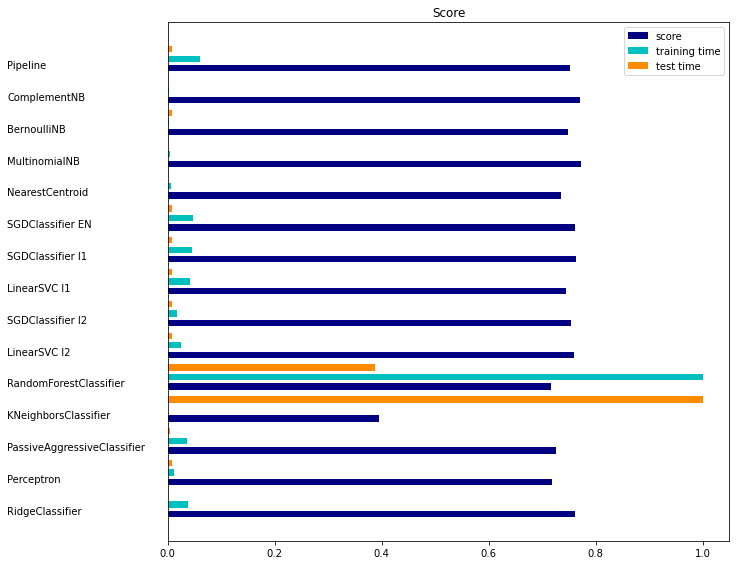

In [126]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()